In [1]:
import tensorflow as tf

# setup a single GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
     # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')        
        gpu_config  = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [gpu_config])
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = "C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/data_7_classes"

In [4]:
#this code checks if the data is ok 
from pathlib import Path
import imghdr


image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [5]:
# Get a list of all the image files in the directory
#this works only with the full directory, not if the images are in the data folder
img_files = [os.path.join(data_dir, f) 
             for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]

In [6]:
#get the class names
class_names = os.listdir(data_dir)
print(class_names)

['apples', 'banana_peels', 'cardboard', 'glass_bottle', 'oranges', 'plastic_packaging', 'smartphone']


In [7]:
# Set the batch size and image size
batch_size = 16
img_size = (299, 299)

# Set the directory containing the images

# Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)


Found 258 files belonging to 7 classes.
Using 207 files for training.
Found 258 files belonging to 7 classes.
Using 51 files for validation.


In [8]:
val_ds.class_names

['apples',
 'banana_peels',
 'cardboard',
 'glass_bottle',
 'oranges',
 'plastic_packaging',
 'smartphone']

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


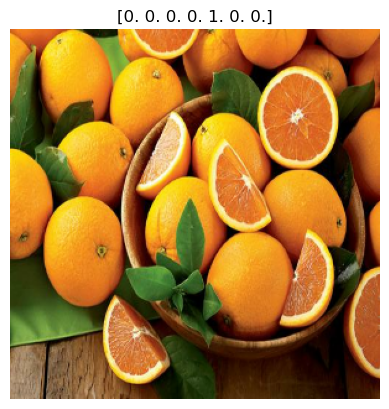

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Take the first batch of images and labels
for images, labels in train_ds.take(1):
    # Convert batch to NumPy array
    np_images = images.numpy()
    np_labels = labels.numpy()

# Plot the first image in the array
plt.imshow(np_images[1].astype('uint8'))
plt.axis('off')
plt.title(np_labels[1])
plt.show()


In [10]:
 np_images.shape

(16, 299, 299, 3)

In [11]:
train_ds.element_spec

(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))

In [12]:
#normalize the dataset
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

In [13]:
#this seems to create problems 
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
tf.keras.layers.RandomRotation(factor=0.05, seed=42),
tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [14]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(labels.shape[1], activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [15]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [16]:
#freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=2)

Epoch 1/2
13/13 [==============================] - 22s 733ms/step - loss: 1.5088 - accuracy: 0.6570 - val_loss: 0.9919 - val_accuracy: 0.8824
Epoch 2/2
13/13 [==============================] - 6s 447ms/step - loss: 0.6554 - accuracy: 0.9372 - val_loss: 0.4946 - val_accuracy: 0.9216


In [18]:
y_true = []
y_pred = []
pred_prob = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    pred_prob_batch = preds.tolist() # convert numpy array to list
    pred_prob.extend(pred_prob_batch)

cm = tf.math.confusion_matrix(y_true, y_pred)

pred_prob = np.array(pred_prob)

1/1 [==============================] - 0s 36ms/step


<AxesSubplot: >

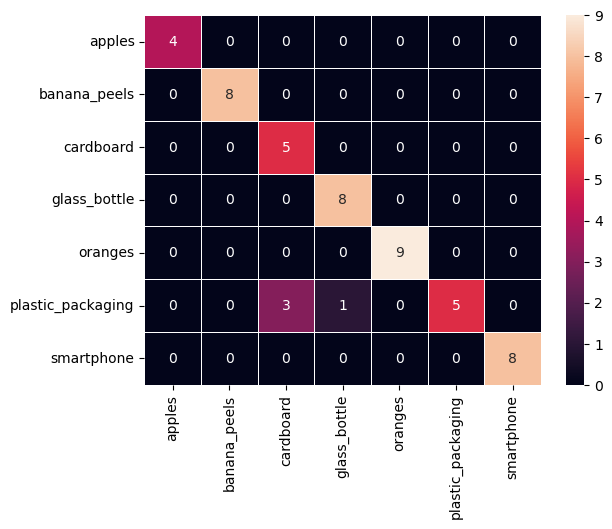

In [19]:
sns.heatmap(cm, annot=True, linewidth=.5, xticklabels=class_names, yticklabels=class_names)

In [20]:
#the index of the pic with the wrong label are extracted
miss_index = []

for i in range (len(y_pred)):
    if y_true[i] != y_pred[i]:
        miss_index.append(i)
        
miss_index = np.array(miss_index)
miss_index

array([12, 19, 24, 39])

In [21]:
#use the index to calculate the batch number and its index in it

miss_tuples = []

for index in miss_index:
    batch_num = index // batch_size  # integer division
    index_within_batch = index % batch_size
    miss_tuples.append((batch_num, index_within_batch))

miss_tuples

[(0, 12), (1, 3), (1, 8), (2, 7)]

1/1 [==============================] - 0s 51ms/step


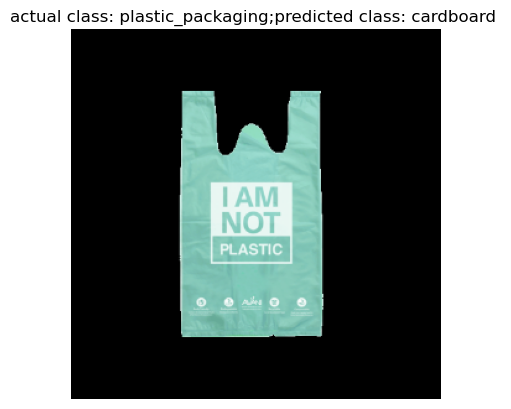

[0. 0. 0. 0. 0. 1. 0.]
probabilities actual: 0.18
probabilities predicted: 0.28


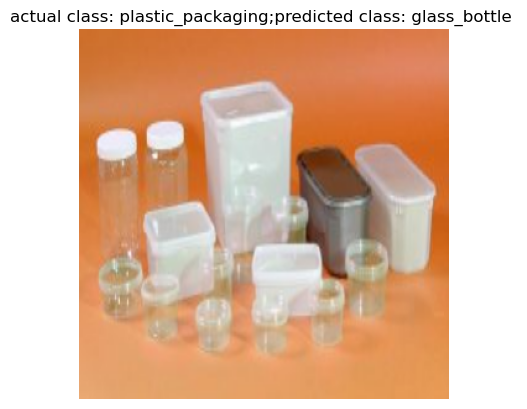

[0. 0. 0. 0. 0. 1. 0.]
probabilities actual: 0.30
probabilities predicted: 0.35
1/1 [==============================] - 0s 63ms/step


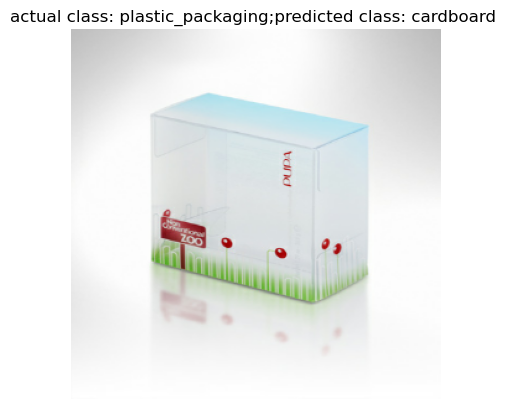

[0. 0. 0. 0. 0. 1. 0.]
probabilities actual: 0.15
probabilities predicted: 0.32
1/1 [==============================] - 0s 79ms/step


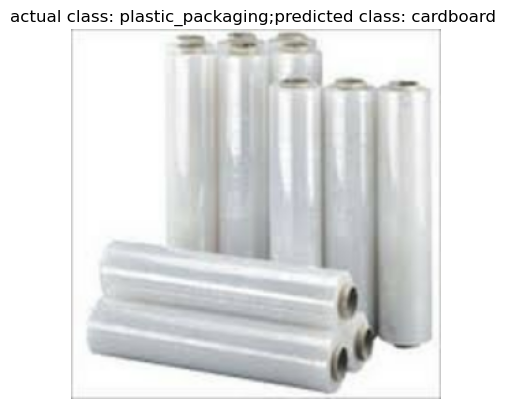

[0. 0. 0. 0. 0. 1. 0.]
probabilities actual: 0.24
probabilities predicted: 0.40
1/1 [==============================] - 0s 59ms/step


In [31]:
#this code is used for showing the images wiht the lo
for images, labels in val_ds:

    preds = model.predict(images)
    
    # Check if predictions match labels
    idx_mismatch = np.where(np.argmax(labels.numpy(), axis=1) != np.argmax(preds, axis=1))[0]
    
    # Plot images with mismatched predictions
    for idx in idx_mismatch:
        np_images = images.numpy()*255
        np_labels = labels.numpy()

        # Display the image
        plt.imshow(np_images[idx].astype('uint8'))
        plt.axis('off')
        plt.title(f"actual class: {class_names[np.argmax(labels.numpy()[idx])]};" 
                  f"predicted class: {class_names[np.argmax(preds[idx])]} ")
        plt.show()
        print(np_labels[idx])
        #check if this is correct but it should be 
        print(f"probabilities actual: {preds[idx][np.argmax(np_labels[idx])]:.2f}")
        print(f"probabilities predicted: {preds[idx][np.argmax(preds[idx])]:.2f}")


In [68]:
#time for some grad-CAM explanation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os

In [33]:
#here we collect all the relevant image paths
#commment them out one by one to check the corresponding image
#these are the images that were misclassified + a test orange image

image_path = 'C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/Test_data/orange.jpeg'
#image_path = 'C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/Test_data/plastic_pack1.jpg'
#image_path = 'C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/Test_data/plastic_pack2.png'
#image_path = 'C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/Test_data/plastic_pack3.jpg'
#image_path = 'C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/Test_data/plastic_pack4.jpg'
#image_path = 'C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/Test_data/plastic_pack5.jpg'

preprocess_input = preprocess_input
IMG_SIZE = (299, 299)

#last conv layer is extracted
#later we need this for the class activation maps (CAMs)
last_conv_layer = "block14_sepconv2_act"


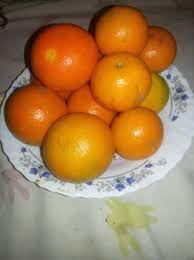

In [34]:
display(Image(image_path))


In [35]:
#applied code from a medium tutorial

def vectorize_image(img_path, size):
    '''
    Vectorize the given image to get a numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) 
    return array

In [36]:
vectorized_image = preprocess_input(vectorize_image(image_path, size=IMG_SIZE))

model_prediction = model.predict(vectorized_image)
print(f"The predicted class is : {class_names[np.argmax(model_prediction)]}")
print (f"probability is: {np.max(model_prediction)*100:.2f}")


1/1 [==============================] - 0s 62ms/step
The predicted class is : oranges
probability is: 49.36


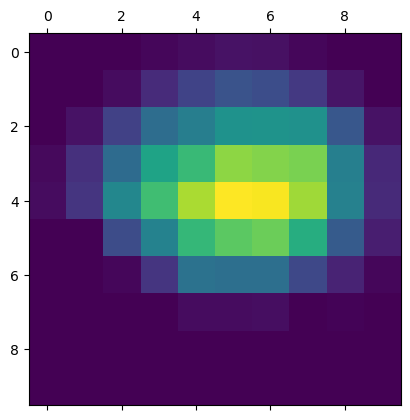

In [37]:
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

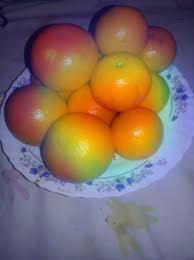

In [38]:
def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image
    
superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))

In [39]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [66]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    # Transforming the image to get the shape as [channel, height, width]
    img = image.img_to_array(img)
    # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = np.expand_dims(img, axis=0)
    # normalizing the image to keep within the range of 0.0 to 1.0
    img = img/255.0 
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

1/1 [==============================] - 0s 290ms/step
the prediction is oranges
with a prob of 0.52


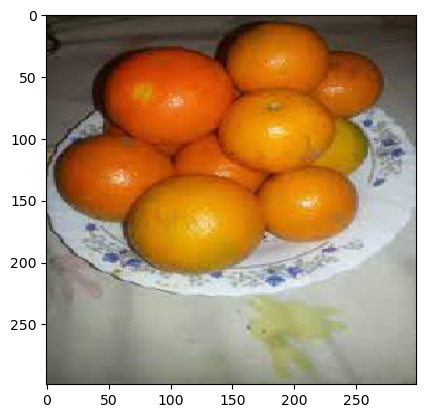

In [141]:
#check image and make prediction
plt.imshow(normalized_img[0])
pred_orig = model.predict(normalized_img)
print (f"the prediction is {class_names[np.argmax(pred_orig)]}")
print (f"with a prob of {np.max(pred_orig):.2f}")

In [175]:
#print out other likely classes
#get order of array based on values, flatten it with ravel 
#and invert it from bigger to smaller
idx_classes = np.argsort(pred_orig).ravel()[::-1]
top_proba = np.sort(pred_orig).ravel()[::-1]
top_classes =  [class_names[i] for i in idx_classes]

print (f"these are the top 3 classes: {top_classes[0:3]}")
print (f"with these probabilities: {top_proba[0:3]*100}")

these are the top 3 classes: ['oranges', 'apples', 'banana_peels']
with these probabilities: [51.8491   21.953362  8.263416]


In [150]:
#LIME instantiation
explainer = lime_image.LimeImageExplainer(kernel_width=0.2)

In [153]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=3, 
                                 hide_color=0, 
                                 num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


In [155]:
#score of the explantion
#how good of an approximation is the LIME linear model of the DL model?
#from 0 to 1, can be thought of as an R squared
exp.score

0.8286334074290778

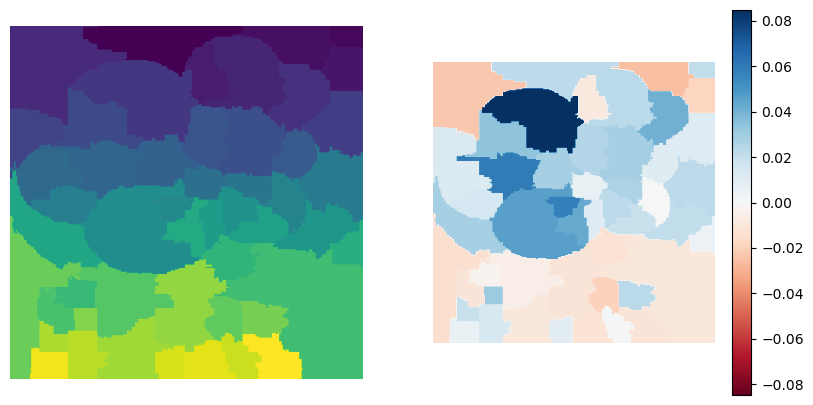

In [162]:
# Plot the image with the superpixel extrapolated by LIME
#the heatmap shows the importance of each superpixel
#here we look at the actual predicted class
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(exp.segments)
ax[0].axis('off')
dict_heatmap = dict(exp.local_exp[exp.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
im = ax[1].imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), 
                  vmax=heatmap.max())
ax[1].axis('off')
plt.colorbar(im)
plt.show()


In [123]:
#show the 5 most important super pixels
def generate_prediction_sample(exp, exp_class, weight = 0.01, 
                               show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box 
    model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=5, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

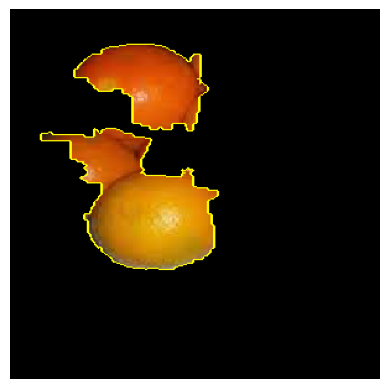

In [158]:
generate_prediction_sample(exp, exp.top_labels[0], 
                           show_positive = True, hide_background = True)

In [177]:
#let´s investigate the second most likely class
print(f"second most likely class: {top_classes[1]}")
print(f"with a probability of: {top_proba[1]*100:.2f}")

second most likely class: apples
with a probability of: 21.95


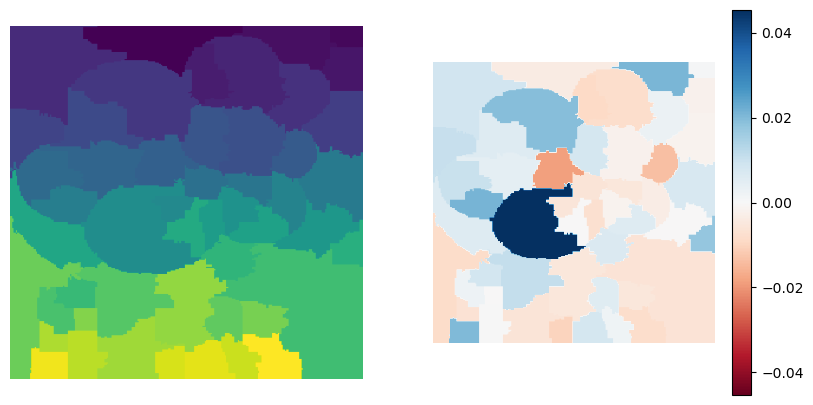

In [178]:
# Plot the image with the superpixel extrapolated by LIME
#the heatmap shows the importance of each superpixel
#here we look at the actual predicted class
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(exp.segments)
ax[0].axis('off')
dict_heatmap = dict(exp.local_exp[exp.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
im = ax[1].imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), 
                  vmax=heatmap.max())
ax[1].axis('off')
plt.colorbar(im)
plt.show()


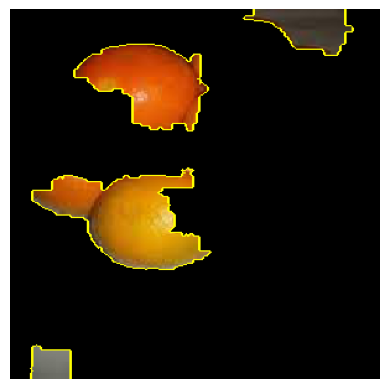

In [179]:
generate_prediction_sample(exp, exp.top_labels[1], 
                           show_positive = True, hide_background = True)